In [240]:
!pip install transformers

In [241]:
# from google.colab import drive
# drive.mount('/content/drive')

In [242]:
#@title import packages

import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans

import torch.nn as nn

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Normalize, Resize, Compose, ToPILImage

In [243]:
#@title Plotting functions

import argparse
import torch
import matplotlib.pyplot as plt
import torchvision.transforms
from torch import nn
from torchvision import transforms
import torch.nn.modules.utils as nn_utils
import math
#import timm
import types
from pathlib import Path
from typing import Union, List, Tuple
from PIL import Image
from matplotlib.colors import ListedColormap

def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    r"""Rescale and displays an image represented as a img.
    The function scales the img :attr:`im` to the [0 ,1] range.
    The img is assumed to have shape :math:`3\times H\times W` (RGB)
    :math:`1\times H\times W` (grayscale).
    Args:
        img (:class:`torch.Tensor` or :class:`PIL.Image`): image.
        quiet (bool, optional): if False, do not display image.
            Default: ``False``.
        lim (list, optional): maximum and minimum intensity value for
            rescaling. Default: ``None``.
        interpolation (str, optional): The interpolation mode to use with
            :func:`matplotlib.pyplot.imshow` (e.g. ``'lanczos'`` or
            ``'nearest'``). Default: ``'lanczos'``.
    Returns:
        :class:`torch.Tensor`: Rescaled image img.
    """
    if isinstance(img, Image.Image):
        img = pil_to_tensor(img)
    handle = None
    with torch.no_grad():
        if not lim:
            lim = [img.min(), img.max()]
        img = img - lim[0]  # also makes a copy
        img.mul_(1 / (lim[1] - lim[0]))
        img = torch.clamp(img, min=0, max=1)
        if not quiet:
            bitmap = img.expand(3,
                                *img.shape[1:]).permute(1, 2, 0).cpu().numpy()
    return bitmap

def draw_correspondences(points1: List[Tuple[float, float]], points2: List[Tuple[float, float]],
                         image1: Image.Image, image2: Image.Image) -> Tuple[plt.Figure, plt.Figure]:
    """
    draw point correspondences on images.
    :param points1: a list of (y, x) coordinates of image1, corresponding to points2.
    :param points2: a list of (y, x) coordinates of image2, corresponding to points1.
    :param image1: a PIL image.
    :param image2: a PIL image.
    :return: two figures of images with marked points.
    """
    assert len(points1) == len(points2), f"points lengths are incompatible: {len(points1)} != {len(points2)}."
    num_points = len(points1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.axis('off')
    ax2.axis('off')
    #ax1.imshow(image1)
    #ax2.imshow(image2)
    ax1.imshow(imsc(image1))
    ax2.imshow(imsc(image2))

    if not points1:
      return fig

    if num_points > 15:
        cmap = plt.get_cmap('tab10')
    else:
        cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                               "maroon", "black", "white", "chocolate", "gray", "blueviolet"])
    colors = np.array([cmap(x) for x in range(num_points)])
    radius1, radius2 = 8, 1
    for point1, point2, color in zip(points1, points2, colors):
        y1, x1 = point1
        circ1_1 = plt.Circle((x1, y1), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ1_2 = plt.Circle((x1, y1), radius2, facecolor=color, edgecolor='white')
        ax1.add_patch(circ1_1)
        ax1.add_patch(circ1_2)
        y2, x2 = point2
        circ2_1 = plt.Circle((x2, y2), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ2_2 = plt.Circle((x2, y2), radius2, facecolor=color, edgecolor='white')
        ax2.add_patch(circ2_1)
        ax2.add_patch(circ2_2)
    return fig

In [244]:
#@title create dataset
from detectron2.data.detection_utils import read_image
from transformers import AutoImageProcessor

#processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")
#processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
#processor = AutoProcessor.from_pretrained("facebook/vit-mae-large")
#processor = AutoProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
#processor.do_center_crop = False

target_mean = [0.485, 0.456, 0.406]
target_std = [0.229, 0.224, 0.225]
processor = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=target_mean, std=target_std)])

class CUB(Dataset):
    def __init__(self, base_path, train=True):

        self.base_path = base_path

        self.labels = pd.read_csv(''.join([base_path, 'image_class_labels.txt']), header=None, sep=" ", names=["id", "label"])
        self.train_test_split = pd.read_csv(''.join([base_path, 'train_test_split.txt']), header=None, sep=" ", names=["id", "is_train"])
        self.filenames = pd.read_csv(''.join([base_path, 'images.txt']), header=None, sep=" ")
        self.filenames = pd.read_csv(''.join([base_path, 'images.txt']), header=None, sep=" ")
        # self.segmentation_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/segmentations/'
        self.segmentation_path = '/mnt/d/Github/SuperpixelCUB/CUB_200_data/segmentations/' # change folder path on your local machine

        self.transforms = Compose([
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

        if train:
          mask = self.train_test_split.is_train.values == 1
        else:
          mask = self.train_test_split.is_train.values == 0

        self.filenames = self.filenames.iloc[mask]
        self.labels = self.labels[mask]

    def __len__(self):
        return self.labels.shape[0]

    # def __getitem__(self, index):

    #     y = self.labels.iloc[index, 1] - 1
    #     file_name = self.filenames.iloc[index, 1]

    #     mask = np.array(Image.open(''.join([self.segmentation_path, file_name.split('.')[0], '.', file_name.split('.')[1], '.png'])).resize((224, 224)))

    #     x = Image.open(''.join([self.base_path, 'images/', file_name])).convert('RGB')
    #     x = processor(x)
    #     # x = read_image(''.join([self.base_path, 'images/', file_name]), format="BGR")

    #     return x, y, (mask >= 1.0) * np.ones_like(mask)
    def __getitem__(self, index):

        y = self.labels.iloc[index, 1] - 1
        file_name = self.filenames.iloc[index, 1]

        # mask = np.array(Image.open(''.join([self.segmentation_path, file_name.split('.')[0], '.', file_name.split('.')[1], '.png'])).resize((224, 224)))

        x = Image.open(''.join([self.base_path, 'images/', file_name])).convert('RGB')
        x = processor(x)
        # x = read_image(''.join([self.base_path, 'images/', file_name]), format="BGR")

        return x, y

data indices:  [5238, 2316]
data indices:  [5275, 2395, 5238, 2316]
[np.int64(175), np.int64(79), np.int64(174), np.int64(77)]


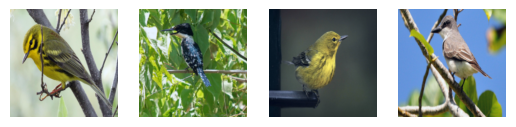

0 /mnt/d/Github/SuperpixelCUB/CUB_200_data/CUB_200_2011/images/176.Prairie_Warbler/Prairie_Warbler_0086_172534.jpg
1 /mnt/d/Github/SuperpixelCUB/CUB_200_data/CUB_200_2011/images/080.Green_Kingfisher/Green_Kingfisher_0037_71113.jpg
2 /mnt/d/Github/SuperpixelCUB/CUB_200_data/CUB_200_2011/images/175.Pine_Warbler/Pine_Warbler_0010_171239.jpg
3 /mnt/d/Github/SuperpixelCUB/CUB_200_data/CUB_200_2011/images/078.Gray_Kingbird/Gray_Kingbird_0045_70256.jpg


In [245]:
#@title dataset and dataloader and load samples

import random
from detectron2.data.detection_utils import read_image
query_transforms = Compose([
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomPerspective(distortion_scale=0.25, p=1.0),
        torchvision.transforms.RandomResizedCrop(size=224, scale=(0.5, 1.0)),
        ])

# base_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/CUB_200_2011/CUB_200_2011/'
base_path = '/mnt/d/Github/SuperpixelCUB/CUB_200_data/CUB_200_2011/' # change folder path on your local machine

train_dataset = CUB(base_path)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
#file_names, x, y = next(iter(train_loader))

NUMBER_OF_PROTOTYPES = 2

random.seed(501)
# inputs, labels, masks = [], [], []
inputs, labels = [], []
#data_indices = []
data_indices = random.sample(range(train_dataset.__len__()), NUMBER_OF_PROTOTYPES)
print("data indices: ", data_indices)
data_indices.insert(0, 2395)
data_indices.insert(0, 5275)
# data_indices.insert(0, 1028)
# data_indices.insert(0, 5260)
# data_indices.insert(0, 912)
# data_indices.insert(0, 925)
# data_indices.insert(0, 2335)
# data_indices.insert(0, 5253)
# data_indices.insert(0, 5250)
# data_indices.insert(0, 1024)
# data_indices.insert(0, 1028)
#data_indices.insert(0, 16)
#data_indices = [153, 151, 213, 244]
print("data indices: ", data_indices)
# for counter, data_idx in enumerate(data_indices):

#   x, y, mask = train_dataset.__getitem__(data_idx)

#   #if counter == 0: x = query_transforms(x)

#   inputs.append(x)
#   labels.append(y)
#   masks.append(mask)
  
for counter, data_idx in enumerate(data_indices):

  x, y = train_dataset.__getitem__(data_idx)

  #if counter == 0: x = query_transforms(x)

  inputs.append(x)
  labels.append(y)
  # masks.append(mask)

print(labels)

plt.figure(1)
plt.subplot(141)
plt.imshow(imsc(inputs[0]))
plt.axis('off')
plt.subplot(142)
plt.imshow(imsc(inputs[1]))
plt.axis('off')
plt.subplot(143)
plt.imshow(imsc(inputs[2]))
plt.axis('off')
plt.subplot(144)
plt.imshow(imsc(inputs[3]))
plt.axis('off')
plt.show()


# The image initializations in VLPart is different. We need to use read_image function
vlpart_inputs = []
for counter, data_idx in enumerate(data_indices):
    # print(counter,data_idx)
    vlpart_x = ''.join([base_path, 'images/', train_dataset.filenames.iloc[data_idx, 1]])
    print(counter,vlpart_x)
    vlpart_x = read_image(''.join([base_path, 'images/', train_dataset.filenames.iloc[data_idx, 1]]), format="BGR")
    vlpart_inputs.append(vlpart_x)

In [246]:
#@title load model


from transformers import AutoProcessor, CLIPVisionModel, Dinov2Model, ViTMAEModel, ViTModel

#model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14").to('cuda')
model = Dinov2Model.from_pretrained("facebook/dinov2-base").to('cuda')
#model = ViTMAEModel.from_pretrained("facebook/vit-mae-large", attn_implementation="eager").to('cuda')
#model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", attn_implementation="eager").to('cuda')


In [247]:
#@title create patch embeddings

IMG_SIZE = x.shape[-1]
print("image size:", IMG_SIZE)

device='cuda'

embedings = []
heatmaps = []

#embedings.append(model.encoder(model.get_input_embeddings()(input_i)).last_hidden_state[0, :, :].numpy(force=True)) MAE thing

with torch.no_grad():

    for counter, input_i in enumerate(inputs):

        input_i = input_i.to(device).unsqueeze(0)

        outputs = model(input_i, output_attentions=True)

        #embedings.append(model.visual_projection(outputs.last_hidden_state[0, 1:, :]).numpy(force=True))
        embedings.append(outputs.last_hidden_state[0, 1:, :].numpy(force=True))

        heatmaps.append(outputs.attentions[0].mean(1)[:, 0, 1:].numpy(force=True))

NUMBER_OF_PATCHES = outputs.last_hidden_state[0, 1:, :].shape[0]
SQRT_NUMBER_OF_PATCHES = int(np.sqrt(NUMBER_OF_PATCHES))
STRIDE = model.config.patch_size #model.get_submodule('embeddings').get_submodule('patch_embeddings').get_submodule('projection').stride[0]
PATCH_SIZE = model.config.patch_size
print("patch size:", PATCH_SIZE)
NUMBER_OF_PATCHES_X = NUMBER_OF_PATCHES_Y = int(IMG_SIZE / PATCH_SIZE)
print("number of patches:", NUMBER_OF_PATCHES)
print("number of patches x:", NUMBER_OF_PATCHES_X)
print("number of patches y:", NUMBER_OF_PATCHES_Y)
LATENT_DIM = embedings[0].shape[-1]

image size: 224
patch size: 14
number of patches: 256
number of patches x: 16
number of patches y: 16


In [ ]:
import glob
import multiprocessing as mp
import numpy as np
import os
import tempfile
import time
import warnings
import cv2
import tqdm
import argparse

from detectron2.config import get_cfg
from detectron2.data.detection_utils import read_image
from detectron2.utils.logger import setup_logger
import sys
from VLPart.vlpart.config import add_vlpart_config
from VLPart.demo.predictor import VisualizationDemo
from detectron2.config import CfgNode

DEFAULT_CONFIG_FILE = "/mnt/d/Github/SuperpixelCUB/VLPart/configs/pascal_part/r50_pascalpart.yaml"
DEFAULT_WEIGHTS = "/mnt/d/Github/SuperpixelCUB/VLPart/checkpoints/r50_pascalpart.pth"
DEFAULT_CONFIDENCE_THRESHOLD = 0.7
# CUSTOM_VOCABULARY =  ["bird beak", "bird head", "bird eye","bird leg", "bird foot", "bird wing", "bird neck", "bird tail","bird torso" ]
CUSTOM_VOCABULARY = ["bird:back", "bird:head", "bird:foot", "bird:neck", "bird:beak", "bird:belly", "bird:breast", "bird:crown", "bird:eye", "bird:wing", "bird:nape", "bird:leg", "bird:torso", "bird:tail"]

def get_parser():
    parser = argparse.ArgumentParser(description="Detectron2 demo for builtin configs")
    parser.add_argument(
        "--config-file",
        default="configs/quick_schedules/mask_rcnn_R_50_FPN_inference_acc_test.yaml",
        metavar="FILE",
        help="path to config file",
    )
    parser.add_argument("--webcam", action="store_true", help="Take inputs from webcam.")
    parser.add_argument("--video-input", help="Path to video file.")
    parser.add_argument(
        "--input",
        nargs="+",
        help="A list of space separated input images; "
        "or a single glob pattern such as 'directory/*.jpg'",
    )
    parser.add_argument(
        "--output",
        help="A file or directory to save output visualizations. "
        "If not given, will show output in an OpenCV window.",
    )
    parser.add_argument(
        "--vocabulary",
        default="pascal_part",
        choices=['pascal_part', 'partimagenet', 'paco',
                 'voc', 'coco', 'lvis',
                 'pascal_part_voc', 'lvis_paco', 'custom'],
        help="",
    )
    parser.add_argument(
        "--custom_vocabulary",
        default="",
        help="",
    )
    parser.add_argument(
        "--confidence-threshold",
        type=float,
        default=0.5,
        help="Minimum score for instance predictions to be shown",
    )

    parser.add_argument(
        "--opts",
        help="Modify config options using the command-line 'KEY VALUE' pairs",
        default=[],
        nargs=argparse.REMAINDER,
    )
    return parser


def setup_cfg(args):
    # load config from file and command-line arguments
    cfg = get_cfg()
    add_vlpart_config(cfg)
    cfg.merge_from_file(args.config_file)
    cfg.MODEL.WEIGHTS = DEFAULT_WEIGHTS
    cfg.merge_from_list(args.opts)
    # Set score_threshold for builtin models
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = DEFAULT_CONFIDENCE_THRESHOLD
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = DEFAULT_CONFIDENCE_THRESHOLD
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = DEFAULT_CONFIDENCE_THRESHOLD
    cfg.freeze()
    return cfg


mp.set_start_method("spawn", force=True)
args = get_parser().parse_args([])
args.config_file = DEFAULT_CONFIG_FILE
args.custom_vocabulary = CUSTOM_VOCABULARY
args.vocabulary = "custom"
args.confidence_threshold  = DEFAULT_CONFIDENCE_THRESHOLD
args.opts.extend(["VIS.BOX", "False"])
setup_logger(name="fvcore")
logger = setup_logger()
logger.info("Arguments: " + str(args))
cfg = setup_cfg(args)

# cfg = setup_cfg()

[03/29 16:21:49 detectron2]: Arguments: Namespace(config_file='/mnt/d/Github/SuperpixelCUB/VLPart/configs/pascal_part/r50_pascalpart.yaml', webcam=False, video_input=None, input=None, output=None, vocabulary='custom', custom_vocabulary=['bird:back', 'bird:head', 'bird:foot', 'bird:neck', 'bird:beak', 'bird:belly', 'bird:breast', 'bird:crown', 'bird:eye', 'bird:wing', 'bird:nape', 'bird:leg', 'bird:torso', 'bird:tail'], confidence_threshold=0.7, opts=['VIS.BOX', 'False'])


In [ ]:
from VLPart.demo.predictor import VisualizationDemo
from detectron2.data.detection_utils import read_image
from detectron2.utils.visualizer import ColorMode, Visualizer, GenericMask

demo = VisualizationDemo(cfg)

vlpart_predictions = []
output_folder = "/mnt/d/Github/SuperpixelCUB/output/"
os.makedirs(output_folder, exist_ok=True)
masks_list = []

print("inputs", len(inputs))
for input_img in tqdm.tqdm(vlpart_inputs):
    predictions, visualized_output = demo.run_on_image(input_img)

    # get prediction results
    pred_masks = predictions["instances"].pred_masks.cpu().numpy()  # shape: [N, H, W]
    pred_classes = predictions["instances"].pred_classes.cpu().numpy()  # shape: [N]

    height, width = input_img.shape[:2]
    semantic_mask = np.zeros((height, width), dtype=np.uint8)

    # combine masks and classes to get semantic mask
    for i in range(len(pred_masks)):
        semantic_mask[pred_masks[i] == 1] = pred_classes[i] + 1  # 

    # save semantic mask to file
    mask_filename = os.path.join(output_folder, f"{time.time()}_semantic_mask.png")
    Image.fromarray(semantic_mask).save(mask_filename)

    # save visualized output to file
    vis_filename = os.path.join(output_folder, f"{time.time()}_vis.jpg")
    visualized_output.save(vis_filename)

    # save original prediction results to list and mask to list
    vlpart_predictions.append(predictions)
    masks_list.append(semantic_mask)
    

Freezing Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Freezing Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act3): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size

/home/chensy/anaconda3/envs/vlpart_env/lib/python3.9/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_lo

WARNING [03/29 16:21:50 fvcore.common.checkpoint]: Some model parameters or buffers are not found in the checkpoint:
backbone.bottom_up.base.bn1.num_batches_tracked
backbone.bottom_up.base.layer1.0.bn1.num_batches_tracked
backbone.bottom_up.base.layer1.0.bn2.num_batches_tracked
backbone.bottom_up.base.layer1.0.bn3.num_batches_tracked
backbone.bottom_up.base.layer1.0.downsample.1.num_batches_tracked
backbone.bottom_up.base.layer1.1.bn1.num_batches_tracked
backbone.bottom_up.base.layer1.1.bn2.num_batches_tracked
backbone.bottom_up.base.layer1.1.bn3.num_batches_tracked
backbone.bottom_up.base.layer1.2.bn1.num_batches_tracked
backbone.bottom_up.base.layer1.2.bn2.num_batches_tracked
backbone.bottom_up.base.layer1.2.bn3.num_batches_tracked
backbone.bottom_up.base.layer2.0.bn1.num_batches_tracked
backbone.bottom_up.base.layer2.0.bn2.num_batches_tracked
backbone.bottom_up.base.layer2.0.bn3.num_batches_tracked
backbone.bottom_up.base.layer2.0.downsample.1.num_batches_tracked
backbone.bottom_up.

100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


In [259]:
from skimage.segmentation import slic, expand_labels
from skimage.transform import resize
from skimage.measure import regionprops

def get_segments(embedding, mask, number_of_patches: int,
                 resize_size: int = 64, number_of_segments: int = 8):

    embedding = embedding.reshape(number_of_patches, number_of_patches, -1)
    embedding = resize(embedding, (resize_size, resize_size))

    mask = resize(mask, (resize_size, resize_size), order=0)

    segments = slic(embedding, n_segments=number_of_segments, mask=mask)

    return segments

In [250]:
from skimage.segmentation import slic, expand_labels
from skimage.transform import resize
from skimage.measure import regionprops

resize_size = 64
all_segments = []
all_keypoints = []

for embeding, mask in zip(embedings, masks_list):
    print("embeding shape:", embeding.shape)
    print("mask shape:", mask.shape)
    embeding = embeding.reshape(NUMBER_OF_PATCHES_X, NUMBER_OF_PATCHES_Y, -1)
    print("before resize embeding:", embeding.shape)
    embeding = resize(embeding, (resize_size, resize_size))
    print("after resize embeding:", embeding.shape)

    resized_mask = resize(mask, (resize_size, resize_size), order=0)
    #resized_mask = expand_labels(resized_mask, distance=4)
    print("resized mask shape:", resized_mask.shape)
    segments = slic(embeding, n_segments=12, compactness=10.0, mask=resized_mask)
    print("segments:", segments.shape)
    all_segments.append(segments)

    low_res_keypoints = np.zeros_like(segments)
    props = regionprops(segments)

    for region_i, prop_i in enumerate(props):
        x_coordinate, y_coordinate = np.int32(np.round(prop_i.centroid))
        low_res_keypoints[x_coordinate, y_coordinate] = region_i+1

    keypoints = np.zeros((224, 224))

    high_res_keypoints = resize(low_res_keypoints, (224, 224), order=0)
    props = regionprops(high_res_keypoints)

    for region_i, prop_i in enumerate(props):
        x_coordinate, y_coordinate = np.int32(np.round(prop_i.centroid))
        keypoints[x_coordinate, y_coordinate] = region_i+1

    all_keypoints.append(np.int32(keypoints))


embeding shape: (256, 768)
mask shape: (333, 500)
before resize embeding: (16, 16, 768)
after resize embeding: (64, 64, 768)
resized mask shape: (64, 64)
segments: (64, 64)
embeding shape: (256, 768)
mask shape: (414, 500)
before resize embeding: (16, 16, 768)
after resize embeding: (64, 64, 768)
resized mask shape: (64, 64)
segments: (64, 64)
embeding shape: (256, 768)
mask shape: (333, 500)
before resize embeding: (16, 16, 768)
after resize embeding: (64, 64, 768)
resized mask shape: (64, 64)
segments: (64, 64)
embeding shape: (256, 768)
mask shape: (275, 500)
before resize embeding: (16, 16, 768)
after resize embeding: (64, 64, 768)
resized mask shape: (64, 64)
segments: (64, 64)


In [251]:
from skimage.transform import resize
from skimage.measure import regionprops
import numpy as np

from detectron2.data import MetadataCatalog

# metadata = MetadataCatalog.get("pascal_part_val")
# class_names = metadata.thing_classes
# print("class names:", class_names)
# class_names = ["bird:beak", "bird:head", "bird:eye", "bird:leg", "bird:foot", "bird:wing", "bird:neck", "bird:tail", "bird:torso"]
class_names = ["bird:background","bird:back", "bird:head", "bird:foot", "bird:neck", "bird:beak", "bird:belly", "bird:breast", "bird:crown", "bird:eye", "bird:wing", "bird:nape", "bird:leg", "bird:torso", "bird:tail"]

all_keypoints_classes = []
all_keypoints_labels = []
# mapping the keypoints with the semantic mask
for semantic_mask, keypoints in zip(masks_list, all_keypoints):
    resized_semantic_mask = resize(semantic_mask, (224, 224), order=0, preserve_range=True).astype(np.uint8)
    keypoint_to_class = {}
    props = regionprops(keypoints)
    for prop in props:
        x, y = np.int32(np.round(prop.centroid))
        keypoint_to_class[prop.label] = resized_semantic_mask[x, y]
    all_keypoints_classes.append(keypoint_to_class)
    
# save the labels of keypoints to list   
for i, kp_class_dict in enumerate(all_keypoints_classes):
    print(f"image{i+1}'s corresponding keypoints class: {kp_class_dict}")
    keypoint_labels = []
    for keypoint_label in kp_class_dict.values():
        if keypoint_label >= len(class_names):
            continue
        keypoint_labels.append(class_names[keypoint_label])
    all_keypoints_labels.append(keypoint_labels)
print(all_keypoints_labels)

image1's corresponding keypoints class: {1: np.uint8(9), 2: np.uint8(16), 3: np.uint8(16), 4: np.uint8(9), 5: np.uint8(13), 6: np.uint8(13), 7: np.uint8(13), 8: np.uint8(13), 9: np.uint8(13), 10: np.uint8(13), 11: np.uint8(0), 12: np.uint8(13), 13: np.uint8(0)}
image2's corresponding keypoints class: {1: np.uint8(9), 2: np.uint8(9), 3: np.uint8(9), 4: np.uint8(9), 5: np.uint8(16), 6: np.uint8(16), 7: np.uint8(16), 8: np.uint8(16), 9: np.uint8(16), 10: np.uint8(16), 11: np.uint8(15), 12: np.uint8(15)}
image3's corresponding keypoints class: {1: np.uint8(9), 2: np.uint8(16), 3: np.uint8(16), 4: np.uint8(15), 5: np.uint8(16), 6: np.uint8(16), 7: np.uint8(16), 8: np.uint8(16), 9: np.uint8(16), 10: np.uint8(16), 11: np.uint8(16)}
image4's corresponding keypoints class: {1: np.uint8(9), 2: np.uint8(9), 3: np.uint8(9), 4: np.uint8(16), 5: np.uint8(16), 6: np.uint8(16), 7: np.uint8(16), 8: np.uint8(16), 9: np.uint8(16), 10: np.uint8(16), 11: np.uint8(15), 12: np.uint8(0)}
[['bird:eye', 'bird:e

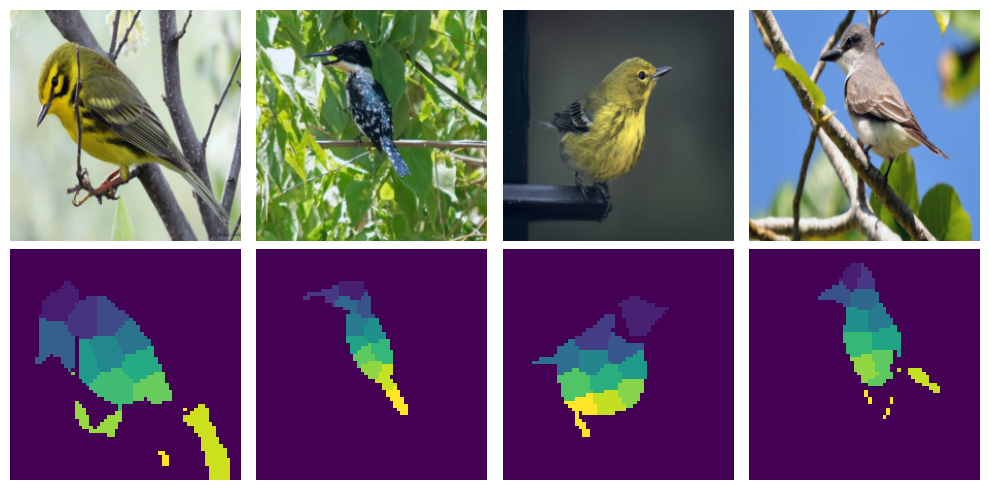

In [252]:
fig, axs = plt.subplots(2, NUMBER_OF_PROTOTYPES+2, figsize=(10, 5))

for col_idx, (image_i, segments_i) in enumerate(zip(inputs, all_segments)):

    axs[0, col_idx].imshow(imsc(image_i))
    axs[0, col_idx].set_axis_off()

    axs[1, col_idx].imshow(segments_i)
    axs[1, col_idx].set_axis_off()

fig.tight_layout()

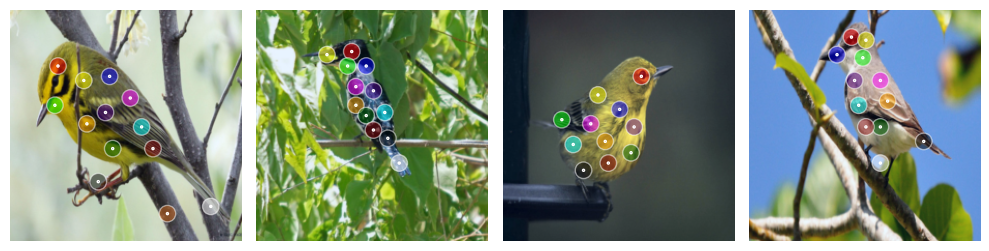

In [253]:
cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                    "maroon", "black", "white", "chocolate", "gray", "blueviolet"])

fig, axs = plt.subplots(1, NUMBER_OF_PROTOTYPES+2, figsize=(10, 5))

for col_idx, (image_i, keypoints_i) in enumerate(zip(inputs, all_keypoints)):

    axs[col_idx].imshow(imsc(image_i))
    axs[col_idx].set_axis_off()

    colors = np.array([cmap(x) for x in range(np.max(keypoints_i))])
    radius1, radius2 = 8, 1

    for keypoint_i, color in zip(np.unique(keypoints_i)[1:], colors):

        y_coordinate, x_coordinate = np.where(keypoints_i==keypoint_i)

        circ1_1 = plt.Circle((x_coordinate, y_coordinate), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ1_2 = plt.Circle((x_coordinate, y_coordinate), radius2, facecolor=color, edgecolor='white')
        axs[col_idx].add_patch(circ1_1)
        axs[col_idx].add_patch(circ1_2)

fig.tight_layout()

In [254]:
number_of_query_regions = 0
number_of_prototype_regions = []
region_means = []

for sample_i, sample_i_segments in enumerate(all_segments):

    sample_i_region_means = []
    embeding = embedings[sample_i].reshape(NUMBER_OF_PATCHES_X, NUMBER_OF_PATCHES_Y, -1)
    embeding = resize(embeding, (resize_size, resize_size)).reshape(-1, LATENT_DIM)

    if sample_i == 0: number_of_query_regions = np.max(sample_i_segments)
    else: number_of_prototype_regions.append(np.max(sample_i_segments))

    for segment_i in np.unique(sample_i_segments)[1:]:

        segment_i_indices = np.where(sample_i_segments.flatten()==segment_i)[0]
        sample_i_region_means.append(np.mean(embeding[segment_i_indices], 0))

    region_means.append(sample_i_region_means)

In [255]:
query_region_means = np.array(region_means[0])

prototype_region_means = np.concatenate(region_means[1:])

nearest_neighbor_query, distances_query = pairwise_distances_argmin_min(query_region_means, prototype_region_means, axis=1, metric='cosine')
nearest_neighbor_prototypes, distances_prototype = pairwise_distances_argmin_min(query_region_means, prototype_region_means, axis=0, metric='cosine')

best_buddies_query = nearest_neighbor_prototypes[nearest_neighbor_query] == np.arange(number_of_query_regions)
best_buddies_prototypes = nearest_neighbor_query[nearest_neighbor_prototypes] == np.arange(np.sum(number_of_prototype_regions))

best_buddies_query_indices = nearest_neighbor_query[best_buddies_query]
best_buddies_prototypes_indices = nearest_neighbor_prototypes[best_buddies_prototypes]

print(best_buddies_query)
print(best_buddies_prototypes)

#best_buddies_query_indices = np.where(nearest_neighbor_prototypes[nearest_neighbor_query] == np.arange(number_of_query_regions))[0]
#best_buddies_prototypes_indices = np.where(nearest_neighbor_query[nearest_neighbor_prototypes] == np.arange(np.sum(number_of_prototype_regions)))[0]

[ True False  True  True False  True  True  True  True False  True False
 False]
[False False False False False False False False False False False False
  True  True False  True  True False  True  True False False False False
 False  True False False False False False False False False  True]


In [256]:
print(best_buddies_query_indices)
print(np.nonzero(best_buddies_query)[0])
print(np.arange(number_of_query_regions)[np.nonzero(best_buddies_query)[0]])
#np.arange(number_of_query_regions)[np.nonzero(best_buddies_query)[0]]

print(np.nonzero(best_buddies_prototypes)[0])
print(np.arange(np.sum(number_of_prototype_regions))[np.nonzero(best_buddies_prototypes)[0]])

[12 13 25 16 18 15 19 34]
[ 0  2  3  5  6  7  8 10]
[ 0  2  3  5  6  7  8 10]
[12 13 15 16 18 19 25 34]
[12 13 15 16 18 19 25 34]


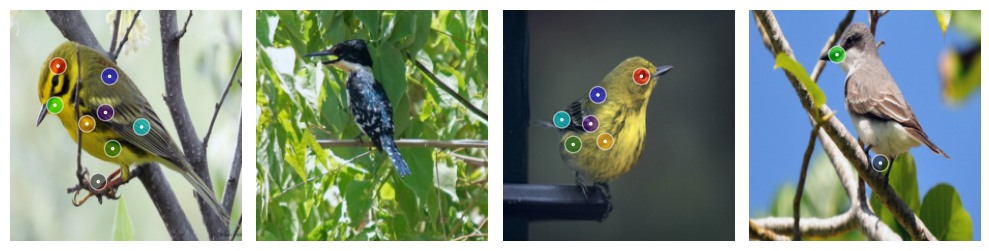

In [257]:
# cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
#                     "maroon", "black", "white", "chocolate", "gray", "blueviolet"])
cmap = ListedColormap([
    "red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
    "maroon", "black", "white", "chocolate", "gray", "blueviolet",
    "olive", "teal", "navy", "coral", "plum", "pink", "gold", "brown", "turquoise", "orchid"
])

# colors = np.array([cmap(x) for x in range(15)])
colors = np.array([cmap(x) for x in range(cmap.N)])

mnn_matches = {}

fig, axs = plt.subplots(1, NUMBER_OF_PROTOTYPES+2, figsize=(10, 5))

for col_idx, (image_i, keypoints_i) in enumerate(zip(inputs, all_keypoints)):

    #print('Sample', col_idx)
    #print(50*'-')

    axs[col_idx].imshow(imsc(image_i))
    axs[col_idx].set_axis_off()

    radius1, radius2 = 8, 1

    for keypoint_counter, keypoint_i in enumerate(np.unique(keypoints_i)[1:]):

        if col_idx == 0:
          if not best_buddies_query[keypoint_i-1]: continue
        elif col_idx == 1:
          if not best_buddies_prototypes[keypoint_i-1]: continue
        else:
          if not best_buddies_prototypes[np.sum(number_of_prototype_regions[:(col_idx-1)])+keypoint_i-1]: continue

        if col_idx == 0:
          color_value = keypoint_counter
          mnn_matches[keypoint_i-1] = color_value
        elif col_idx == 1:
          color_value = mnn_matches[nearest_neighbor_prototypes[keypoint_i-1]]
        else:
          color_value = mnn_matches[nearest_neighbor_prototypes[np.sum(number_of_prototype_regions[:(col_idx-1)])+keypoint_i-1]]

        
        y_coordinate, x_coordinate = np.where(keypoints_i==keypoint_i)

        circ1_1 = plt.Circle((x_coordinate, y_coordinate), radius1, facecolor=colors[color_value], edgecolor='white', alpha=0.5)
        circ1_2 = plt.Circle((x_coordinate, y_coordinate), radius2, facecolor=colors[color_value], edgecolor='white')
        axs[col_idx].add_patch(circ1_1)
        axs[col_idx].add_patch(circ1_2)


fig.tight_layout()

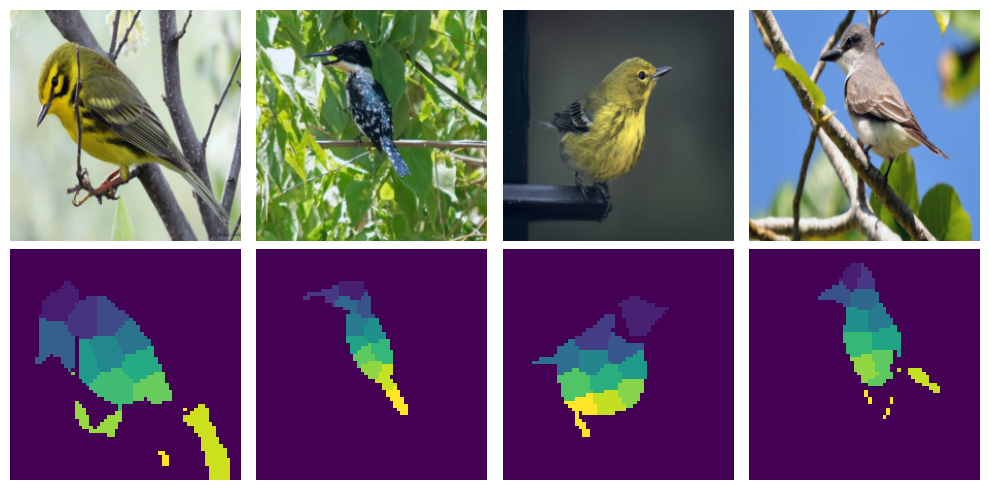

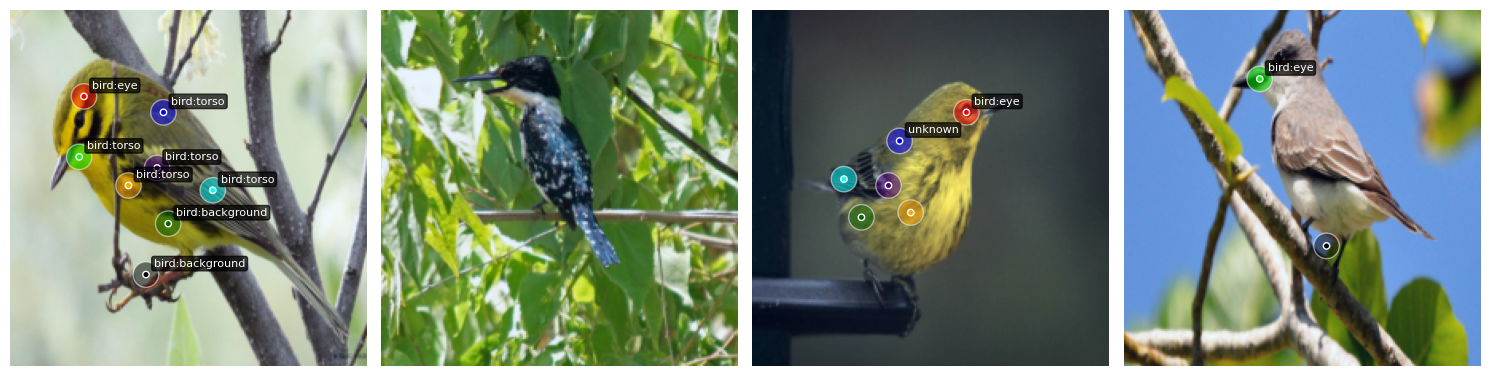

In [258]:

fig, axs = plt.subplots(2, NUMBER_OF_PROTOTYPES+2, figsize=(10, 5))

for col_idx, (image_i, segments_i) in enumerate(zip(inputs, all_segments)):

    axs[0, col_idx].imshow(imsc(image_i))
    axs[0, col_idx].set_axis_off()

    axs[1, col_idx].imshow(segments_i)
    axs[1, col_idx].set_axis_off()

fig.tight_layout()

cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange",
                       "cyan", "darkgreen", "maroon", "black", "white", "chocolate",
                       "gray", "blueviolet"])
colors = np.array([cmap(x) for x in range(15)])

mnn_matches = {}
fig, axs = plt.subplots(1, NUMBER_OF_PROTOTYPES + 2, figsize=(15, 5))

for col_idx, (image_i, keypoints_mask, keypoints_labels) in enumerate(zip(inputs, all_keypoints, all_keypoints_labels)):

    axs[col_idx].imshow(imsc(image_i))
    axs[col_idx].set_axis_off()

    radius1, radius2 = 8, 2
    unique_keypoints = np.unique(keypoints_mask)[1:]  # remove background
    for keypoint_idx, keypoint_value in enumerate(unique_keypoints):
        if col_idx == 0:
            if not best_buddies_query[keypoint_value - 1]: continue
            color_value = keypoint_idx
            mnn_matches[keypoint_value - 1] = color_value
        elif col_idx == 1:
            if not best_buddies_prototypes[keypoint_value - 1]: continue
            color_value = mnn_matches[nearest_neighbor_prototypes[keypoint_value - 1]]
        else:
            proto_offset = np.sum(number_of_prototype_regions[:(col_idx - 1)]) + keypoint_value - 1
            if not best_buddies_prototypes[proto_offset]: continue
            color_value = mnn_matches[nearest_neighbor_prototypes[proto_offset]]

        # get coordinates of the keypoint
        y_coords, x_coords = np.where(keypoints_mask == keypoint_value)
        mean_x, mean_y = np.mean(x_coords), np.mean(y_coords)

        # plot the keypoint
        circ1 = plt.Circle((mean_x, mean_y), radius1, facecolor=colors[color_value], edgecolor='white', alpha=0.5)
        circ2 = plt.Circle((mean_x, mean_y), radius2, facecolor=colors[color_value], edgecolor='white')
        axs[col_idx].add_patch(circ1)
        axs[col_idx].add_patch(circ2)

        # get the label of the keypoint
        if keypoint_idx > len(keypoints_labels):
            continue       
        elif keypoint_idx < len(keypoints_labels):
            label_text = keypoints_labels[keypoint_idx]
        else:
            label_text = 'unknown'
        # show labels
        axs[col_idx].text(mean_x + 5, mean_y - 5, label_text, fontsize=8, color='white',
                        bbox=dict(facecolor='black', alpha=0.7, boxstyle='round,pad=0.2'))

fig.tight_layout()
plt.show()
